# Homework 3 - Logistic Regression
**Estimated completion time: 2.5 hours (including write-up)**

**Goal:** Build a binary **multiple logistic regression** model to predict **`status`** (`0 = alive`, `1 = deceased`) from predictors in the ISLP [**Brain Cancer**](https://islp.readthedocs.io/en/latest/datasets/BrainCancer.html) dataset.

**Workflow:**

0) **Setup packages and load dataset**
1) **Simple EDA**
2) **Fit a binary outcome, multiple logistic regression model** to predict **`status`** using `statsmodels.Logit`
3) **Predict and evaluate with `sklearn.LogisticRegression`**
4) Compute **classification accuracy** and **ROC/AUC** (test).

> **Comments marked **# YOUR CODE HERE** must be completed for the code to run

> **Please also make sure you are pasting your plots and answering any questions in the document in the **main homework document**, not in this notebook.

## 0) Setup (imports)
If running locally and something is missing, install `ISLP`, `statsmodels`, and `scikit-learn`.

In [1]:
!pip install -q ISLP statsmodels scikit-learn pandas numpy matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 120)


[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: pip install --upgrade pip


## 0) Load & sanity-check the Brain Cancer data

**Checking the dataset:**
1. Load the dataset (try `from ISLP import load_data; load_data('BrainCancer')`, else fallback to `BrainCancer.csv`).  
2. Clean column names (optional).  
3. Show `df.shape` and the first few rows.

In [2]:
try:
    from ISLP import load_data
    df = load_data('BrainCancer')
except Exception:
    df = pd.read_csv('BrainCancer.csv')

df.columns = df.columns.str.replace(r'[^0-9a-zA-Z]+', '_', regex=True)
print(df.shape)
df.head()

(88, 8)


,sex,diagnosis,loc,ki,gtv,stereo,status,time
0,Female,Meningioma,Infratentorial,90,6.11,SRS,0,57.64
1,Male,HG glioma,Supratentorial,90,19.35,SRT,1,8.98
2,Female,Meningioma,Infratentorial,70,7.95,SRS,0,26.46
3,Female,LG glioma,Supratentorial,80,7.61,SRT,1,47.80
4,Male,HG glioma,Supratentorial,90,5.06,SRT,1,6.30


## 1) Quick EDA
1. Count the number of `status=0` and `status=1` (use `value_counts()` and `value_counts(normalize=True)`).  
2. (Optional) Show simple summaries for `ki` and `gtv` (use `df[['ki','gtv']].describe()` if present).

In [4]:
display(df['status'].value_counts(dropna=False))
display(df['status'].value_counts(normalize=True))

for col in ['ki','gtv']:
    if col in df.columns:
        display(df[[col]].describe())

status
0    53
1    35
Name: count, dtype: int64

status
0    0.602273
1    0.397727
Name: proportion, dtype: float64

,ki
count,88.000000
mean,81.022727
std,10.508866
min,40.000000
25%,80.000000
50%,80.000000
75%,90.000000
max,100.000000


,gtv
count,88.000000
mean,8.660795
std,8.657576
min,0.010000
25%,2.500000
50%,6.510000
75%,12.100000
max,34.640000


## 2) Prepare data for fitting
**We define:**
- **Outcome:** `status` (0 = alive, 1 = deceased).
- **Predictors:** `sex`, `diagnosis`, `loc`, `ki`, `gtv`.

Cleaning up the training data (ensure no NaNs):
1. Use `df.dropna` to drop any row that has a missing value in 'status'
2. `subset=['status'] + predictors` combines the outcome with the predictors so all required columns must be non-missing.
3. `.copy()` makes a new data frame

In [5]:
predictors = ['sex','diagnosis','loc','ki','gtv'] # our predictors
data = df.dropna(subset=['status'] + predictors).copy()

**Steps to implement (with function hints):**
- Use `train_test_split(..., stratify=...)` with stratification on `status`. Split the data into 70% train and 30% test and use `stratify=data['status']` to ensure there's same proportion of `status = 0s/1s` in both splits as in the full data.

In [9]:
train_df, test_df = train_test_split(data, test_size = 0.3, stratify = data['status'])

y_train = train_df['status'].astype(int)
y_test  = test_df['status'].astype(int)

num_cols = ['ki','gtv'] # assign numerical (quantitative) predictors
cat_cols = ['sex','diagnosis','loc'] # assign categorical (qualitative) predictors

# code the dummy variables for the categorical variables in train and test
X_train_cat = pd.get_dummies(train_df[cat_cols], drop_first=True)
X_test_cat  = pd.get_dummies(test_df[cat_cols],  drop_first=True)
X_test_cat = X_test_cat.reindex(columns=X_train_cat.columns, fill_value=0) # aligning columns for test data

# check what the baseline variable in your dummy coding: will be useful later for interpretation
print("Baseline (reference) category for diagnosis:", sorted(train_df['diagnosis'].unique())[0]) # baseline variable for diagnosis
print("Baseline (reference) category for sex:", sorted(train_df['sex'].unique())[0]) # baseline variable for sex
print("Baseline (reference) category for location:", sorted(train_df['loc'].unique())[0]) # baseline variable for location

# standardize numeric features in train and test
scaler = StandardScaler().fit(train_df[num_cols])
X_train_num = pd.DataFrame(scaler.transform(train_df[num_cols]), columns=num_cols, index=train_df.index)
X_test_num  = pd.DataFrame(scaler.transform(test_df[num_cols]),  columns=num_cols, index=test_df.index)

# put numerical and categorical features back together
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test  = pd.concat([X_test_num,  X_test_cat],  axis=1)

X_train = X_train.astype(float) # convert categorical booleans to ints because statsmodels can't take booleans

X_train.shape, X_test.shape, y_train.value_counts().to_dict()

Baseline (reference) category for diagnosis: HG glioma
Baseline (reference) category for sex: Female
Baseline (reference) category for location: Infratentorial


((60, 7), (27, 7), {0: 36, 1: 24})

## 3) Fit logistic regression with **`statsmodels.Logit`**

**TO-DO:**
1. Add intercept to `X_train` using `sm.add_constant(..., has_constant='add')`.  
2. Fit: `Logit(y_train, X).fit(...)`.  
3. Print the summary.  
4. Compute **odds ratios** by exponentiating the coefficients

**Function hints:** `sm.add_constant`, `Logit(y, X).fit()`, `.summary()`, `np.exp(params)` (odds ratios).

In [11]:
X = sm.add_constant(X_train, has_constant='add')
logit_mod = Logit(y_train, X).fit()

print(logit_mod.summary()) # print summary
print(np.exp(logit_mod.params)) # print the exponentiated coefficients

Optimization terminated successfully.
         Current function value: 0.494835
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 status   No. Observations:                   60
Model:                          Logit   Df Residuals:                       52
Method:                           MLE   Df Model:                            7
Date:                Thu, 16 Oct 2025   Pseudo R-squ.:                  0.2647
Time:                        22:02:28   Log-Likelihood:                -29.690
converged:                       True   LL-Null:                       -40.381
Covariance Type:            nonrobust   LLR p-value:                  0.003245
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.2125      1.368      0.155      0.877      -2.468       2.893

## 4) Predict & **assess with Accuracy and ROC/AUC** (test) using **`sklearn`**
**Function hints:**  
- `LogisticRegression(max_iter=1000).fit(X_train, y_train)`  
- `predict(X)` → class labels; `predict_proba(X)[:, 1]` → class-1 probabilities  
- `accuracy_score(y_true, y_pred)`  
- `roc_auc_score(y_true, y_score)` with **probabilities** for the positive class  
- `roc_curve(y_true, y_score)` to get `fpr, tpr, thresholds`  
- Use `matplotlib.pyplot` to **plot the ROC curve**

**Steps:**
1. Fit a `LogisticRegression` on `X_train, y_train`.  
2. Predict **test** labels and **test** probabilities.  
3. Compute **accuracy (train/test)** and **ROC AUC (test)**. Print them.  
4. Plot the **ROC curve**.

Naive baseline (majority class accuracy): 0.593
Accuracy (train): 0.783
Accuracy (test): 0.630
AUC (test):      0.852


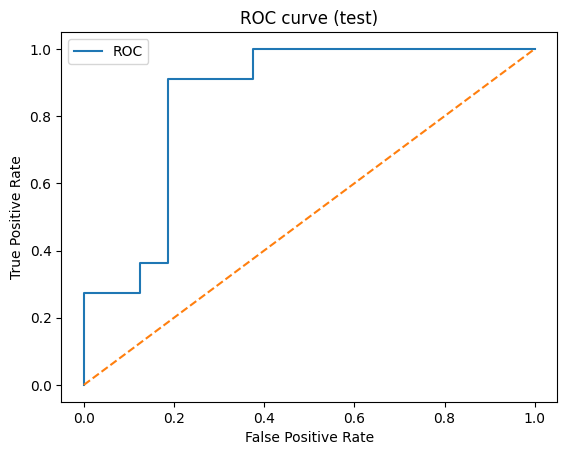

In [14]:
sk_log = LogisticRegression(max_iter = 1000).fit(X_train, y_train)

yhat_tr = sk_log.predict(X_train) # (predict using train X)
yhat_te = sk_log.predict(X_test) # (predict using test X)
proba_te = sk_log.predict_proba(X_test)[:, 1] # predict status = 1 probabilities

baseline_rate = y_test.value_counts(normalize=True).max() # baseline rate for majority class accuracy
acc_tr = accuracy_score(y_train, yhat_tr) # YOUR CODE HERE (train accuracy)
acc_te = accuracy_score(y_test, yhat_te) # YOUR CODE HERE (test accuracy)
auc_te = roc_auc_score(y_test, proba_te) # YOUR CODE HERE (roc auc test score)

print("Naive baseline (majority class accuracy):", round(baseline_rate, 3))
print(f"Accuracy (train): {acc_tr:.3f}")
print(f"Accuracy (test): {acc_te:.3f}")
print(f"AUC (test):      {auc_te:.3f}")

fpr, tpr, thr = roc_curve(y_test, proba_te)
plt.figure()
plt.plot(fpr, tpr, label='ROC')
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve (test)')
plt.legend()
plt.show()